In [1]:
!pip install import-ipynb

  Created wheel for import-ipynb: filename=import_ipynb-0.1.3-py3-none-any.whl size=2975 sha256=5d8b597131c77a138936ab12506fbc3d4cb6a5952cc07617366bd2777f7288ea
  Stored in directory: /root/.cache/pip/wheels/b1/5e/dc/79780689896a056199b0b9f24471e3ee184fbd816df355d5f0
Successfully built import-ipynb


In [5]:
import import_ipynb
import UNET_MultiClass
from UNET_MultiClass import multi_unet

importing Jupyter notebook from UNET_MultiClass.ipynb


In [6]:
from keras.utils.np_utils import normalize
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
height = 128
width = 128
channels = 1
num_classes = 4

train_images = []
for directory_path in sorted(glob.glob("/content/drive/MyDrive/ColabNotebooks/deep learning /Object_Segmentation/images")):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        img = cv2.imread(img_path, 0)       
        train_images.append(img)
train_images = np.array(train_images)

train_masks = []

for directory_path in sorted(glob.glob("/content/drive/MyDrive/ColabNotebooks/deep learning /Object_Segmentation/masks_final")):
    for img_path in glob.glob(os.path.join(directory_path, "*.tif")):
        img = cv2.imread(img_path, 0)       
        train_masks.append(img)
train_masks = np.array(train_masks)

In [8]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
n, h, w = train_masks.shape
train_masks_reshaped = train_masks.reshape(-1,1).ravel()
train_masks_encoder = labelencoder.fit_transform(train_masks_reshaped)
train_masks_ = train_masks_encoder.reshape(n, h, w)

In [9]:
train_images = np.expand_dims(train_images, axis=3)
train_images = normalize(train_images, axis=1)

In [10]:
train_masks_input = np.expand_dims(train_masks_, axis=3)

In [11]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(train_images, train_masks_input, test_size = 0.10, random_state = 0)

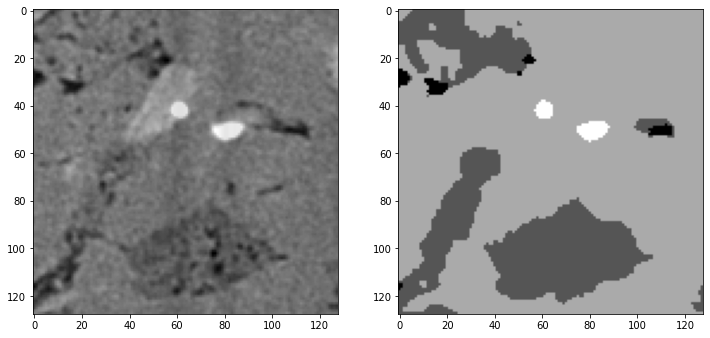

In [17]:
import random
idx = random.randint(0, len(X_train))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(X_train[idx], (128, 128)), cmap='gray')
plt.subplot(122)
plt.imshow(np.reshape(y_train[idx], (128, 128)), cmap='gray')
plt.show()

In [18]:
from tensorflow.keras.utils import to_categorical
train_masks_cat = to_categorical(y_train, num_classes=4)
test_masks_cat = to_categorical(y_test, num_classes=4)

In [19]:
height, width, channels = X_train.shape[1:]
model = multi_unet(4, height, width, channels)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

In [21]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [22]:
history = model.fit(X_train, train_masks_cat, 
                    batch_size = 16, 
                    verbose=1, 
                    epochs=20, 
                    validation_data=(X_test, test_masks_cat),
                    shuffle=False)

Epoch 1/20
90/90 [==============================] - 23s 113ms/step - loss: 0.6604 - accuracy: 0.7969 - val_loss: 0.4019 - val_accuracy: 0.8810
Epoch 2/20
90/90 [==============================] - 10s 111ms/step - loss: 0.4064 - accuracy: 0.8752 - val_loss: 0.3144 - val_accuracy: 0.8919
Epoch 3/20
90/90 [==============================] - 10s 109ms/step - loss: 0.3292 - accuracy: 0.8841 - val_loss: 0.2514 - val_accuracy: 0.9073
Epoch 4/20
90/90 [==============================] - 10s 111ms/step - loss: 0.2800 - accuracy: 0.8989 - val_loss: 0.2107 - val_accuracy: 0.9229
Epoch 5/20
90/90 [==============================] - 10s 111ms/step - loss: 0.2369 - accuracy: 0.9159 - val_loss: 0.1902 - val_accuracy: 0.9305
Epoch 6/20
90/90 [==============================] - 10s 108ms/step - loss: 0.2150 - accuracy: 0.9241 - val_loss: 0.1686 - val_accuracy: 0.9391
Epoch 7/20
90/90 [==============================] - 10s 112ms/step - loss: 0.1959 - accuracy: 0.9307 - val_loss: 0.1594 - val_accuracy: 0.9432

In [23]:
model.save('/content/drive/MyDrive/Colab Notebooks/deep learning /Object_Segmentation/h5_files/sandstone_multi_seg.hdf5')

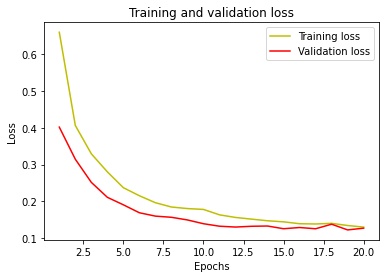

In [24]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [25]:
y_pred=model.predict(X_test)
y_pred_=np.argmax(y_pred, axis=3)

In [26]:
from keras.metrics import MeanIoU
n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test[:,:,:,0], y_pred_)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.84363365


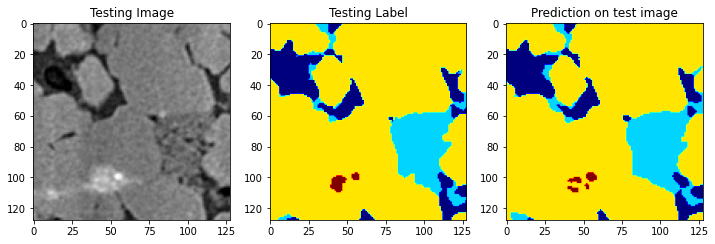

In [29]:
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]
ground_truth=y_test[test_img_number]
test_img_norm=test_img[:,:,0][:,:,None]
test_img_input=np.expand_dims(test_img_norm, 0)
prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]


plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,0], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth[:,:,0], cmap='jet')
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img, cmap='jet')
plt.show()